# Hard Attention MNIST

This is jupyter notebook for `Hard Attention` from paper [Show, Attend and Tell](https://arxiv.org/abs/1502.03044). 
<br>This Algorithm will be tested by `Modified MNIST dataset` Which is made by [Jongwon Park](https://github.com/jwpark116). <br>This modified MNIST dataset is good for verifying attention algorithm.
<br>You can download modified MNIST data from this link
<br>[Training dataset](https://www.dropbox.com/s/e7jxyulxx2anqyq/MNIST_data_train_re.mat?dl=0)  /  [Testing dataset](https://www.dropbox.com/s/fcw4754bavva9my/MNIST_data_test_re.mat?dl=0)

In [1]:
# Import modules
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import random
import skimage.transform

/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Import MNIST data

mat_data_train = scipy.io.loadmat('MNIST_data_train_re.mat')
mat_data_test = scipy.io.loadmat('MNIST_data_test_re.mat')

train_x = mat_data_train['X_train']
train_y = mat_data_train['Y_train']

test_x = mat_data_test['X_test'][:9900, :]
test_y = mat_data_test['Y_test'][:9900, :]

validation_x = mat_data_test['X_test'][9900:, :]
validation_y = mat_data_test['Y_test'][9900:, :]

del mat_data_train
del mat_data_test

print("Train data shape: " + str(train_x.shape))
print("Train label shape: " + str(train_y.shape))
print("Test data shape: " + str(test_x.shape))
print("Test label shape: " + str(test_y.shape))
print("Validation data shape: " + str(validation_x.shape))
print("Validation label shape: " + str(validation_y.shape))

Train data shape: (55000, 112, 112)
Train label shape: (55000, 10)
Test data shape: (9900, 112, 112)
Test label shape: (9900, 10)
Validation data shape: (100, 112, 112)
Validation label shape: (100, 10)


## Parameters

In [3]:
# Parameters 
img_size = train_x.shape[1]
img_flat_size = img_size * img_size

# If you want to train the model -> True, otherwise -> False
Is_train = True

# If you want to load saved model -> True, otherwise -> False 
Load_model = False

# Name of the save file
save_name = 'hard1'

# Numbers of sampling to test the code 
num_test_sample = 10

# labels: 0 - 9
num_label = 10

# Parameters for training
num_epoch = 10

learning_rate = 5e-4
epsilon = 1e-8

batch_size = 256

# Parameter for LSTM
lstm_size = 256
step_size = 4
flatten_size = img_size

gpu_fraction = 0.3

## Plotting Sample Image (Modified MNIST for Attention)

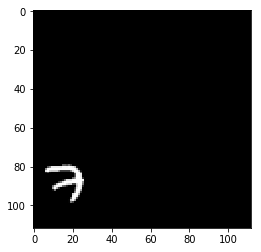

Label: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Shape: 112x112


In [4]:
# Plotting example image
img = train_x[0, :, :]

plt.imshow(img, cmap = 'gray')
plt.show()
print('Label: ' + str(train_y[0,:]))
print('Shape: ' + str(img_size) + 'x' + str(img_size))

## Functions for Convolutional Network

In [5]:
# Initialize weights and bias 
def conv2d(x,w, stride):
	return tf.nn.conv2d(x,w,strides=[1, stride, stride, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

# Get Variables
def weight_variable(name, shape):
    return tf.get_variable(name,shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(name, shape):
    return tf.get_variable(name,shape=shape, initializer=tf.contrib.layers.xavier_initializer())

## LSTM and Attention function

In [21]:
# Reset the graph
tf.reset_default_graph()

# LSTM function
def LSTM_cell(C_prev, h_prev, x_lstm, Wf, Wi, Wc, Wo, bf, bi, bc, bo):
    # C_prev: Cell state from lstm of previous time step (shape: [batch_size, lstm_size])
    # h_prev: output from lstm of previous time step (shape: [batch_size, lstm_size])
    # x_lstm: input of lstm (shape: [batch_size, data_flatten_size])

    input_concat = tf.concat([x_lstm, h_prev], 1)
    f = tf.sigmoid(tf.matmul(input_concat, Wf) + bf)
    i = tf.sigmoid(tf.matmul(input_concat, Wi) + bi)
    c = tf.tanh(tf.matmul(input_concat, Wc) + bc)
    o = tf.sigmoid(tf.matmul(input_concat, Wo) + bo)
    
    C_t = tf.multiply(f, C_prev) + tf.multiply(i, c) 
    h_t = tf.multiply(o, tf.tanh(C_t))
    
    return C_t, h_t # Cell state, Output

# Hard Attention function
def hard_attention(h_prev, a, Wa, Wh):
    # h_prev: output from lstm of previous time step (shape: [batch_size, lstm_size])
    # a: Result of CNN [batch_size, conv_size * conv_size, channel_size] 

    m_list = [tf.tanh(tf.matmul(a[i], Wa) + tf.matmul(h_prev, Wh)) for i in range(len(a))] 
    m_concat = tf.concat([m_list[i] for i in range(len(a))], axis = 1)     
    alpha = tf.nn.softmax(m_concat) 
    
    #For Monte-Carlo Sampling
    alpha_cumsum = tf.cumsum(alpha, axis = 1)
    len_batch = tf.shape(alpha_cumsum)[0]
    rand_prob = tf.random_uniform(shape = [len_batch, 1], minval = 0., maxval = 1.)
    alpha_relu = tf.nn.relu(rand_prob - alpha_cumsum)
    alpha_index = tf.count_nonzero(alpha_relu, 1)
    alpha_hard  = tf.one_hot(alpha_index, len(a))

    z_list = [tf.multiply(a[i], tf.slice(alpha_hard, (0, i), (-1, 1))) for i in range(len(a))]
    z_stack = tf.stack(z_list, axis = 2)
    z = tf.reduce_sum(z_stack, axis = 2)

    return alpha, z
    

## Network

In [22]:
# Network

# Input 
x_image  = tf.placeholder(tf.float32, shape = [None, img_size, img_size, 1])
y_target = tf.placeholder(tf.float32, shape=[None, num_label])

# Convolution variables
w_conv1 = weight_variable('W_conv1', [3, 3, 1, 64])
b_conv1 = bias_variable('b_conv1', [64])
w_conv2 = weight_variable('W_conv2', [3, 3, 64, 256])
b_conv2 = bias_variable('b_conv2', [256])
w_conv3 = weight_variable('W_conv3', [3, 3, 256, 512])
b_conv3 = bias_variable('b_conv3', [512])

conv1 = tf.nn.relu(conv2d(x_image, w_conv1, 2) + b_conv1)
conv2 = tf.nn.relu(conv2d(conv1, w_conv2, 2) + b_conv2)
conv3 = tf.nn.relu(conv2d(conv2, w_conv3, 2) + b_conv3)

conv_size = conv3.get_shape()[1]
conv_flat = tf.reshape(conv3, [-1, conv_size*conv_size, 512])
conv_unstack = tf.unstack(conv_flat, axis = 1)

#LSTM Variables
Wf = weight_variable('Wf', [512 + lstm_size, lstm_size])
Wi = weight_variable('Wi', [512 + lstm_size, lstm_size])
Wc = weight_variable('Wc', [512 + lstm_size, lstm_size])
Wo = weight_variable('Wo', [512 + lstm_size, lstm_size])

bf = bias_variable('bf', [lstm_size])
bi = bias_variable('bi', [lstm_size])
bc = bias_variable('bc', [lstm_size])
bo = bias_variable('bo', [lstm_size]) 

# Attention Variables
Wa = weight_variable('Wa', [512, 1])
Wh = weight_variable('Wh', [lstm_size, 1])

rnn_batch_size = tf.shape(x_image)[0]

# Initial lstm cell state and output 
rnn_state = tf.zeros([rnn_batch_size, lstm_size], tf.float32)
rnn_out = tf.zeros([rnn_batch_size, lstm_size], tf.float32)

#################################### Attention!!! ####################################
for i in range(step_size):
    alpha, z = hard_attention(rnn_out, conv_unstack, Wa, Wh)
    rnn_state, rnn_out = LSTM_cell(rnn_state, rnn_out, z, Wf, Wi, Wc, Wo, bf, bi, bc, bo)

######################################################################################

# Densely connect layer variables 
w_fc1 = weight_variable('w_fc1', [lstm_size, num_label])
b_fc1 = bias_variable('b_fc1', [num_label])

output = tf.matmul(rnn_out, w_fc1)+b_fc1

# Training 
Loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = y_target, logits = output)
Cost = tf.reduce_mean(Loss)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, epsilon = epsilon).minimize(Cost)

correct_prediction = tf.equal(tf.argmax(y_target,1), tf.argmax(output,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


## Create Session

In [23]:
# Create Session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = gpu_fraction

sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

## Save and Restore

In [24]:
# Load the file if the saved file exists
saver = tf.train.Saver()
if Load_model == True:
    checkpoint = tf.train.get_checkpoint_state("saved_networks/")
    if checkpoint and checkpoint.model_checkpoint_path:
        saver.restore(sess, checkpoint.model_checkpoint_path)
        print("Successfully loaded:", checkpoint.model_checkpoint_path)
    else:
        print("Could not find old network weights")

## Training

In [25]:
# Training

if Is_train == True:
    train_data_num = train_x.shape[0]

    for i in range(num_epoch):
        # Making batches
        random_idx = np.arange(train_data_num)
        np.random.shuffle(random_idx)

        batch_count = 1
    
        for j in range(0, train_data_num, batch_size):
            if j + batch_size < train_data_num:
                batch_index = [j, j + batch_size]

                batch_x_train = train_x[random_idx[batch_index[0]:batch_index[1]],:,:]
                batch_y_train = train_y[random_idx[batch_index[0]:batch_index[1]],:]
            else:
                batch_index = [j, j + train_data_num-1]

                batch_x_train = train_x[random_idx[batch_index[0]:batch_index[-1]],:,:]
                batch_y_train = train_y[random_idx[batch_index[0]:batch_index[-1]],:]

            # Make image as fractions for attention
            train_batch = np.reshape(batch_x_train, (batch_x_train.shape[0], img_size, img_size, 1))
            validation_batch = np.reshape(validation_x, (validation_x.shape[0], img_size, img_size, 1))
            
            # Training
            optimizer.run(feed_dict = {x_image: train_batch, y_target: batch_y_train})
            cost = sess.run(Cost, feed_dict = {x_image: train_batch, y_target: batch_y_train})
            acc = sess.run(accuracy, feed_dict = {x_image: train_batch, y_target: batch_y_train})
            val_acc = sess.run(accuracy, feed_dict = {x_image: validation_batch, y_target: validation_y})

            # Print Progress
            print("Epoch: " + str(i+1) + ' / ' + 
                  "Batch: " + str(j) + '/' + str(train_data_num) + ' / ' + 
                  "Cost: " + str(cost) + ' / ' + 
                  "Training Accuracy: " + str(acc) + ' / ' + 
                  "Validation Accuracy: " + str(val_acc))  

        saver.save(sess, 'saved_networks/' + save_name)
        print('Model is saved!!!')

Epoch: 1 / Batch: 0/55000 / Cost: 0.7089118 / Training Accuracy: 0.08203125 / Validation Accuracy: 0.12
Epoch: 1 / Batch: 256/55000 / Cost: 0.6575832 / Training Accuracy: 0.109375 / Validation Accuracy: 0.07
Epoch: 1 / Batch: 512/55000 / Cost: 0.596373 / Training Accuracy: 0.12109375 / Validation Accuracy: 0.09
Epoch: 1 / Batch: 768/55000 / Cost: 0.53163093 / Training Accuracy: 0.0859375 / Validation Accuracy: 0.06
Epoch: 1 / Batch: 1024/55000 / Cost: 0.4478686 / Training Accuracy: 0.08984375 / Validation Accuracy: 0.05
Epoch: 1 / Batch: 1280/55000 / Cost: 0.37945113 / Training Accuracy: 0.09375 / Validation Accuracy: 0.11
Epoch: 1 / Batch: 1536/55000 / Cost: 0.3397128 / Training Accuracy: 0.1171875 / Validation Accuracy: 0.1
Epoch: 1 / Batch: 1792/55000 / Cost: 0.32891458 / Training Accuracy: 0.0859375 / Validation Accuracy: 0.1
Epoch: 1 / Batch: 2048/55000 / Cost: 0.33275068 / Training Accuracy: 0.12890625 / Validation Accuracy: 0.14
Epoch: 1 / Batch: 2304/55000 / Cost: 0.34443575 / 

Epoch: 1 / Batch: 19712/55000 / Cost: 0.3258218 / Training Accuracy: 0.13671875 / Validation Accuracy: 0.12
Epoch: 1 / Batch: 19968/55000 / Cost: 0.32428098 / Training Accuracy: 0.15234375 / Validation Accuracy: 0.12
Epoch: 1 / Batch: 20224/55000 / Cost: 0.32421035 / Training Accuracy: 0.14453125 / Validation Accuracy: 0.12
Epoch: 1 / Batch: 20480/55000 / Cost: 0.3261025 / Training Accuracy: 0.10546875 / Validation Accuracy: 0.12
Epoch: 1 / Batch: 20736/55000 / Cost: 0.3263854 / Training Accuracy: 0.10546875 / Validation Accuracy: 0.12
Epoch: 1 / Batch: 20992/55000 / Cost: 0.32544813 / Training Accuracy: 0.12109375 / Validation Accuracy: 0.12
Epoch: 1 / Batch: 21248/55000 / Cost: 0.32574147 / Training Accuracy: 0.1015625 / Validation Accuracy: 0.12
Epoch: 1 / Batch: 21504/55000 / Cost: 0.32322267 / Training Accuracy: 0.140625 / Validation Accuracy: 0.12
Epoch: 1 / Batch: 21760/55000 / Cost: 0.32654127 / Training Accuracy: 0.10546875 / Validation Accuracy: 0.12
Epoch: 1 / Batch: 22016/5

Epoch: 1 / Batch: 39424/55000 / Cost: 0.32496557 / Training Accuracy: 0.1171875 / Validation Accuracy: 0.12
Epoch: 1 / Batch: 39680/55000 / Cost: 0.32443872 / Training Accuracy: 0.140625 / Validation Accuracy: 0.12
Epoch: 1 / Batch: 39936/55000 / Cost: 0.32548797 / Training Accuracy: 0.109375 / Validation Accuracy: 0.12
Epoch: 1 / Batch: 40192/55000 / Cost: 0.3245928 / Training Accuracy: 0.109375 / Validation Accuracy: 0.12
Epoch: 1 / Batch: 40448/55000 / Cost: 0.32690126 / Training Accuracy: 0.10546875 / Validation Accuracy: 0.12
Epoch: 1 / Batch: 40704/55000 / Cost: 0.32561487 / Training Accuracy: 0.12109375 / Validation Accuracy: 0.12
Epoch: 1 / Batch: 40960/55000 / Cost: 0.32385796 / Training Accuracy: 0.11328125 / Validation Accuracy: 0.12
Epoch: 1 / Batch: 41216/55000 / Cost: 0.32642558 / Training Accuracy: 0.12890625 / Validation Accuracy: 0.12
Epoch: 1 / Batch: 41472/55000 / Cost: 0.3252377 / Training Accuracy: 0.10546875 / Validation Accuracy: 0.12
Epoch: 1 / Batch: 41728/5500

Epoch: 2 / Batch: 4096/55000 / Cost: 0.32513255 / Training Accuracy: 0.11328125 / Validation Accuracy: 0.11
Epoch: 2 / Batch: 4352/55000 / Cost: 0.32466978 / Training Accuracy: 0.140625 / Validation Accuracy: 0.11
Epoch: 2 / Batch: 4608/55000 / Cost: 0.32488078 / Training Accuracy: 0.10546875 / Validation Accuracy: 0.1
Epoch: 2 / Batch: 4864/55000 / Cost: 0.32429925 / Training Accuracy: 0.08984375 / Validation Accuracy: 0.11
Epoch: 2 / Batch: 5120/55000 / Cost: 0.3255024 / Training Accuracy: 0.10546875 / Validation Accuracy: 0.08
Epoch: 2 / Batch: 5376/55000 / Cost: 0.32523817 / Training Accuracy: 0.10546875 / Validation Accuracy: 0.11
Epoch: 2 / Batch: 5632/55000 / Cost: 0.32513404 / Training Accuracy: 0.11328125 / Validation Accuracy: 0.11
Epoch: 2 / Batch: 5888/55000 / Cost: 0.3259781 / Training Accuracy: 0.08984375 / Validation Accuracy: 0.11
Epoch: 2 / Batch: 6144/55000 / Cost: 0.32433134 / Training Accuracy: 0.09765625 / Validation Accuracy: 0.11
Epoch: 2 / Batch: 6400/55000 / Co

Epoch: 2 / Batch: 23808/55000 / Cost: 0.32354409 / Training Accuracy: 0.1640625 / Validation Accuracy: 0.15
Epoch: 2 / Batch: 24064/55000 / Cost: 0.3253104 / Training Accuracy: 0.09765625 / Validation Accuracy: 0.12
Epoch: 2 / Batch: 24320/55000 / Cost: 0.32582572 / Training Accuracy: 0.0859375 / Validation Accuracy: 0.12
Epoch: 2 / Batch: 24576/55000 / Cost: 0.32558623 / Training Accuracy: 0.109375 / Validation Accuracy: 0.12
Epoch: 2 / Batch: 24832/55000 / Cost: 0.32415375 / Training Accuracy: 0.1328125 / Validation Accuracy: 0.15
Epoch: 2 / Batch: 25088/55000 / Cost: 0.3258462 / Training Accuracy: 0.09375 / Validation Accuracy: 0.12
Epoch: 2 / Batch: 25344/55000 / Cost: 0.32473657 / Training Accuracy: 0.1015625 / Validation Accuracy: 0.12
Epoch: 2 / Batch: 25600/55000 / Cost: 0.32466757 / Training Accuracy: 0.078125 / Validation Accuracy: 0.12
Epoch: 2 / Batch: 25856/55000 / Cost: 0.3255294 / Training Accuracy: 0.0703125 / Validation Accuracy: 0.1
Epoch: 2 / Batch: 26112/55000 / Cos

Epoch: 2 / Batch: 43520/55000 / Cost: 0.32542244 / Training Accuracy: 0.10546875 / Validation Accuracy: 0.15
Epoch: 2 / Batch: 43776/55000 / Cost: 0.32621688 / Training Accuracy: 0.11328125 / Validation Accuracy: 0.15
Epoch: 2 / Batch: 44032/55000 / Cost: 0.32361713 / Training Accuracy: 0.1171875 / Validation Accuracy: 0.14
Epoch: 2 / Batch: 44288/55000 / Cost: 0.32436615 / Training Accuracy: 0.12109375 / Validation Accuracy: 0.14
Epoch: 2 / Batch: 44544/55000 / Cost: 0.32547852 / Training Accuracy: 0.12109375 / Validation Accuracy: 0.13
Epoch: 2 / Batch: 44800/55000 / Cost: 0.32464448 / Training Accuracy: 0.1484375 / Validation Accuracy: 0.12
Epoch: 2 / Batch: 45056/55000 / Cost: 0.32357544 / Training Accuracy: 0.1328125 / Validation Accuracy: 0.15
Epoch: 2 / Batch: 45312/55000 / Cost: 0.32399976 / Training Accuracy: 0.09765625 / Validation Accuracy: 0.11
Epoch: 2 / Batch: 45568/55000 / Cost: 0.3239603 / Training Accuracy: 0.08984375 / Validation Accuracy: 0.11
Epoch: 2 / Batch: 45824

Epoch: 3 / Batch: 8192/55000 / Cost: 0.32562816 / Training Accuracy: 0.10546875 / Validation Accuracy: 0.13
Epoch: 3 / Batch: 8448/55000 / Cost: 0.32331187 / Training Accuracy: 0.16796875 / Validation Accuracy: 0.13
Epoch: 3 / Batch: 8704/55000 / Cost: 0.32547185 / Training Accuracy: 0.1328125 / Validation Accuracy: 0.15
Epoch: 3 / Batch: 8960/55000 / Cost: 0.3246092 / Training Accuracy: 0.125 / Validation Accuracy: 0.14
Epoch: 3 / Batch: 9216/55000 / Cost: 0.322915 / Training Accuracy: 0.16015625 / Validation Accuracy: 0.13
Epoch: 3 / Batch: 9472/55000 / Cost: 0.32364556 / Training Accuracy: 0.10546875 / Validation Accuracy: 0.19
Epoch: 3 / Batch: 9728/55000 / Cost: 0.32400727 / Training Accuracy: 0.1328125 / Validation Accuracy: 0.13
Epoch: 3 / Batch: 9984/55000 / Cost: 0.32476416 / Training Accuracy: 0.12890625 / Validation Accuracy: 0.15
Epoch: 3 / Batch: 10240/55000 / Cost: 0.3240643 / Training Accuracy: 0.13671875 / Validation Accuracy: 0.12
Epoch: 3 / Batch: 10496/55000 / Cost: 

Epoch: 3 / Batch: 27904/55000 / Cost: 0.3219093 / Training Accuracy: 0.1640625 / Validation Accuracy: 0.16
Epoch: 3 / Batch: 28160/55000 / Cost: 0.32227677 / Training Accuracy: 0.140625 / Validation Accuracy: 0.19
Epoch: 3 / Batch: 28416/55000 / Cost: 0.319911 / Training Accuracy: 0.1484375 / Validation Accuracy: 0.17
Epoch: 3 / Batch: 28672/55000 / Cost: 0.32342577 / Training Accuracy: 0.1484375 / Validation Accuracy: 0.18
Epoch: 3 / Batch: 28928/55000 / Cost: 0.32443485 / Training Accuracy: 0.125 / Validation Accuracy: 0.18
Epoch: 3 / Batch: 29184/55000 / Cost: 0.3219519 / Training Accuracy: 0.15625 / Validation Accuracy: 0.12
Epoch: 3 / Batch: 29440/55000 / Cost: 0.3209079 / Training Accuracy: 0.14453125 / Validation Accuracy: 0.18
Epoch: 3 / Batch: 29696/55000 / Cost: 0.321072 / Training Accuracy: 0.125 / Validation Accuracy: 0.18
Epoch: 3 / Batch: 29952/55000 / Cost: 0.32346362 / Training Accuracy: 0.1484375 / Validation Accuracy: 0.15
Epoch: 3 / Batch: 30208/55000 / Cost: 0.32132

Epoch: 3 / Batch: 47616/55000 / Cost: 0.31732446 / Training Accuracy: 0.171875 / Validation Accuracy: 0.16
Epoch: 3 / Batch: 47872/55000 / Cost: 0.3185164 / Training Accuracy: 0.1640625 / Validation Accuracy: 0.13
Epoch: 3 / Batch: 48128/55000 / Cost: 0.31898698 / Training Accuracy: 0.16796875 / Validation Accuracy: 0.14
Epoch: 3 / Batch: 48384/55000 / Cost: 0.3187852 / Training Accuracy: 0.17578125 / Validation Accuracy: 0.12
Epoch: 3 / Batch: 48640/55000 / Cost: 0.31505144 / Training Accuracy: 0.19140625 / Validation Accuracy: 0.17
Epoch: 3 / Batch: 48896/55000 / Cost: 0.31696787 / Training Accuracy: 0.15234375 / Validation Accuracy: 0.18
Epoch: 3 / Batch: 49152/55000 / Cost: 0.31346554 / Training Accuracy: 0.2421875 / Validation Accuracy: 0.19
Epoch: 3 / Batch: 49408/55000 / Cost: 0.31652898 / Training Accuracy: 0.15234375 / Validation Accuracy: 0.17
Epoch: 3 / Batch: 49664/55000 / Cost: 0.31939384 / Training Accuracy: 0.13671875 / Validation Accuracy: 0.19
Epoch: 3 / Batch: 49920/5

Epoch: 4 / Batch: 12288/55000 / Cost: 0.3158524 / Training Accuracy: 0.22265625 / Validation Accuracy: 0.23
Epoch: 4 / Batch: 12544/55000 / Cost: 0.31225523 / Training Accuracy: 0.21484375 / Validation Accuracy: 0.19
Epoch: 4 / Batch: 12800/55000 / Cost: 0.31407732 / Training Accuracy: 0.17578125 / Validation Accuracy: 0.21
Epoch: 4 / Batch: 13056/55000 / Cost: 0.31424055 / Training Accuracy: 0.1640625 / Validation Accuracy: 0.2
Epoch: 4 / Batch: 13312/55000 / Cost: 0.3108164 / Training Accuracy: 0.1875 / Validation Accuracy: 0.19
Epoch: 4 / Batch: 13568/55000 / Cost: 0.31310123 / Training Accuracy: 0.18359375 / Validation Accuracy: 0.15
Epoch: 4 / Batch: 13824/55000 / Cost: 0.31212053 / Training Accuracy: 0.171875 / Validation Accuracy: 0.19
Epoch: 4 / Batch: 14080/55000 / Cost: 0.31341404 / Training Accuracy: 0.16796875 / Validation Accuracy: 0.22
Epoch: 4 / Batch: 14336/55000 / Cost: 0.3139965 / Training Accuracy: 0.1796875 / Validation Accuracy: 0.18
Epoch: 4 / Batch: 14592/55000 /

Epoch: 4 / Batch: 32000/55000 / Cost: 0.31115708 / Training Accuracy: 0.20703125 / Validation Accuracy: 0.27
Epoch: 4 / Batch: 32256/55000 / Cost: 0.30617374 / Training Accuracy: 0.1875 / Validation Accuracy: 0.2
Epoch: 4 / Batch: 32512/55000 / Cost: 0.3069448 / Training Accuracy: 0.234375 / Validation Accuracy: 0.23
Epoch: 4 / Batch: 32768/55000 / Cost: 0.30884773 / Training Accuracy: 0.23046875 / Validation Accuracy: 0.17
Epoch: 4 / Batch: 33024/55000 / Cost: 0.30899414 / Training Accuracy: 0.1796875 / Validation Accuracy: 0.23
Epoch: 4 / Batch: 33280/55000 / Cost: 0.3074965 / Training Accuracy: 0.1796875 / Validation Accuracy: 0.19
Epoch: 4 / Batch: 33536/55000 / Cost: 0.30917186 / Training Accuracy: 0.1875 / Validation Accuracy: 0.24
Epoch: 4 / Batch: 33792/55000 / Cost: 0.30636844 / Training Accuracy: 0.21484375 / Validation Accuracy: 0.26
Epoch: 4 / Batch: 34048/55000 / Cost: 0.30381316 / Training Accuracy: 0.21875 / Validation Accuracy: 0.23
Epoch: 4 / Batch: 34304/55000 / Cost:

Epoch: 4 / Batch: 51712/55000 / Cost: 0.30566382 / Training Accuracy: 0.19921875 / Validation Accuracy: 0.21
Epoch: 4 / Batch: 51968/55000 / Cost: 0.3035021 / Training Accuracy: 0.21875 / Validation Accuracy: 0.22
Epoch: 4 / Batch: 52224/55000 / Cost: 0.29895157 / Training Accuracy: 0.23828125 / Validation Accuracy: 0.19
Epoch: 4 / Batch: 52480/55000 / Cost: 0.29899377 / Training Accuracy: 0.23828125 / Validation Accuracy: 0.19
Epoch: 4 / Batch: 52736/55000 / Cost: 0.30911902 / Training Accuracy: 0.24609375 / Validation Accuracy: 0.29
Epoch: 4 / Batch: 52992/55000 / Cost: 0.3012647 / Training Accuracy: 0.25 / Validation Accuracy: 0.21
Epoch: 4 / Batch: 53248/55000 / Cost: 0.2988456 / Training Accuracy: 0.27734375 / Validation Accuracy: 0.2
Epoch: 4 / Batch: 53504/55000 / Cost: 0.30566555 / Training Accuracy: 0.21875 / Validation Accuracy: 0.24
Epoch: 4 / Batch: 53760/55000 / Cost: 0.30419755 / Training Accuracy: 0.22265625 / Validation Accuracy: 0.19
Epoch: 4 / Batch: 54016/55000 / Cos

Epoch: 5 / Batch: 16384/55000 / Cost: 0.29683825 / Training Accuracy: 0.21875 / Validation Accuracy: 0.2
Epoch: 5 / Batch: 16640/55000 / Cost: 0.30138943 / Training Accuracy: 0.19140625 / Validation Accuracy: 0.23
Epoch: 5 / Batch: 16896/55000 / Cost: 0.29594287 / Training Accuracy: 0.28515625 / Validation Accuracy: 0.21
Epoch: 5 / Batch: 17152/55000 / Cost: 0.30353776 / Training Accuracy: 0.2265625 / Validation Accuracy: 0.23
Epoch: 5 / Batch: 17408/55000 / Cost: 0.29808584 / Training Accuracy: 0.21875 / Validation Accuracy: 0.2
Epoch: 5 / Batch: 17664/55000 / Cost: 0.29921627 / Training Accuracy: 0.203125 / Validation Accuracy: 0.21
Epoch: 5 / Batch: 17920/55000 / Cost: 0.30371165 / Training Accuracy: 0.18359375 / Validation Accuracy: 0.22
Epoch: 5 / Batch: 18176/55000 / Cost: 0.30268124 / Training Accuracy: 0.2265625 / Validation Accuracy: 0.18
Epoch: 5 / Batch: 18432/55000 / Cost: 0.30245304 / Training Accuracy: 0.2265625 / Validation Accuracy: 0.21
Epoch: 5 / Batch: 18688/55000 / 

Epoch: 5 / Batch: 36096/55000 / Cost: 0.3015486 / Training Accuracy: 0.23828125 / Validation Accuracy: 0.22
Epoch: 5 / Batch: 36352/55000 / Cost: 0.29871127 / Training Accuracy: 0.22265625 / Validation Accuracy: 0.27
Epoch: 5 / Batch: 36608/55000 / Cost: 0.30036336 / Training Accuracy: 0.2265625 / Validation Accuracy: 0.23
Epoch: 5 / Batch: 36864/55000 / Cost: 0.3006605 / Training Accuracy: 0.265625 / Validation Accuracy: 0.16
Epoch: 5 / Batch: 37120/55000 / Cost: 0.29301152 / Training Accuracy: 0.22265625 / Validation Accuracy: 0.2
Epoch: 5 / Batch: 37376/55000 / Cost: 0.2898607 / Training Accuracy: 0.29296875 / Validation Accuracy: 0.27
Epoch: 5 / Batch: 37632/55000 / Cost: 0.29755956 / Training Accuracy: 0.24609375 / Validation Accuracy: 0.2
Epoch: 5 / Batch: 37888/55000 / Cost: 0.29648456 / Training Accuracy: 0.234375 / Validation Accuracy: 0.26
Epoch: 5 / Batch: 38144/55000 / Cost: 0.29575425 / Training Accuracy: 0.25390625 / Validation Accuracy: 0.23
Epoch: 5 / Batch: 38400/55000

Epoch: 6 / Batch: 768/55000 / Cost: 0.28972876 / Training Accuracy: 0.2578125 / Validation Accuracy: 0.26
Epoch: 6 / Batch: 1024/55000 / Cost: 0.29527053 / Training Accuracy: 0.2734375 / Validation Accuracy: 0.31
Epoch: 6 / Batch: 1280/55000 / Cost: 0.29293624 / Training Accuracy: 0.23828125 / Validation Accuracy: 0.26
Epoch: 6 / Batch: 1536/55000 / Cost: 0.29087156 / Training Accuracy: 0.21484375 / Validation Accuracy: 0.21
Epoch: 6 / Batch: 1792/55000 / Cost: 0.30112058 / Training Accuracy: 0.26953125 / Validation Accuracy: 0.25
Epoch: 6 / Batch: 2048/55000 / Cost: 0.29328504 / Training Accuracy: 0.1796875 / Validation Accuracy: 0.26
Epoch: 6 / Batch: 2304/55000 / Cost: 0.29271883 / Training Accuracy: 0.22265625 / Validation Accuracy: 0.21
Epoch: 6 / Batch: 2560/55000 / Cost: 0.29531282 / Training Accuracy: 0.23828125 / Validation Accuracy: 0.26
Epoch: 6 / Batch: 2816/55000 / Cost: 0.29267436 / Training Accuracy: 0.23828125 / Validation Accuracy: 0.28
Epoch: 6 / Batch: 3072/55000 / C

Epoch: 6 / Batch: 20480/55000 / Cost: 0.28603607 / Training Accuracy: 0.2578125 / Validation Accuracy: 0.29
Epoch: 6 / Batch: 20736/55000 / Cost: 0.29888457 / Training Accuracy: 0.1796875 / Validation Accuracy: 0.23
Epoch: 6 / Batch: 20992/55000 / Cost: 0.29210526 / Training Accuracy: 0.234375 / Validation Accuracy: 0.25
Epoch: 6 / Batch: 21248/55000 / Cost: 0.2946996 / Training Accuracy: 0.25390625 / Validation Accuracy: 0.23
Epoch: 6 / Batch: 21504/55000 / Cost: 0.29518074 / Training Accuracy: 0.23828125 / Validation Accuracy: 0.25
Epoch: 6 / Batch: 21760/55000 / Cost: 0.29129672 / Training Accuracy: 0.2109375 / Validation Accuracy: 0.22
Epoch: 6 / Batch: 22016/55000 / Cost: 0.29476658 / Training Accuracy: 0.23046875 / Validation Accuracy: 0.26
Epoch: 6 / Batch: 22272/55000 / Cost: 0.2961325 / Training Accuracy: 0.19921875 / Validation Accuracy: 0.25
Epoch: 6 / Batch: 22528/55000 / Cost: 0.29921928 / Training Accuracy: 0.22265625 / Validation Accuracy: 0.3
Epoch: 6 / Batch: 22784/550

Epoch: 6 / Batch: 40192/55000 / Cost: 0.29663584 / Training Accuracy: 0.24609375 / Validation Accuracy: 0.27
Epoch: 6 / Batch: 40448/55000 / Cost: 0.29675743 / Training Accuracy: 0.23828125 / Validation Accuracy: 0.22
Epoch: 6 / Batch: 40704/55000 / Cost: 0.29419035 / Training Accuracy: 0.2890625 / Validation Accuracy: 0.19
Epoch: 6 / Batch: 40960/55000 / Cost: 0.28485978 / Training Accuracy: 0.265625 / Validation Accuracy: 0.3
Epoch: 6 / Batch: 41216/55000 / Cost: 0.29494005 / Training Accuracy: 0.28125 / Validation Accuracy: 0.22
Epoch: 6 / Batch: 41472/55000 / Cost: 0.288802 / Training Accuracy: 0.25390625 / Validation Accuracy: 0.28
Epoch: 6 / Batch: 41728/55000 / Cost: 0.28956938 / Training Accuracy: 0.26953125 / Validation Accuracy: 0.31
Epoch: 6 / Batch: 41984/55000 / Cost: 0.28840172 / Training Accuracy: 0.234375 / Validation Accuracy: 0.29
Epoch: 6 / Batch: 42240/55000 / Cost: 0.2910338 / Training Accuracy: 0.2265625 / Validation Accuracy: 0.3
Epoch: 6 / Batch: 42496/55000 / C

Epoch: 7 / Batch: 4864/55000 / Cost: 0.28598812 / Training Accuracy: 0.25 / Validation Accuracy: 0.27
Epoch: 7 / Batch: 5120/55000 / Cost: 0.2848344 / Training Accuracy: 0.234375 / Validation Accuracy: 0.32
Epoch: 7 / Batch: 5376/55000 / Cost: 0.2970917 / Training Accuracy: 0.27734375 / Validation Accuracy: 0.24
Epoch: 7 / Batch: 5632/55000 / Cost: 0.2901995 / Training Accuracy: 0.28515625 / Validation Accuracy: 0.25
Epoch: 7 / Batch: 5888/55000 / Cost: 0.28900033 / Training Accuracy: 0.2890625 / Validation Accuracy: 0.3
Epoch: 7 / Batch: 6144/55000 / Cost: 0.28760964 / Training Accuracy: 0.26171875 / Validation Accuracy: 0.25
Epoch: 7 / Batch: 6400/55000 / Cost: 0.29009846 / Training Accuracy: 0.28125 / Validation Accuracy: 0.27
Epoch: 7 / Batch: 6656/55000 / Cost: 0.28971562 / Training Accuracy: 0.24609375 / Validation Accuracy: 0.33
Epoch: 7 / Batch: 6912/55000 / Cost: 0.29444295 / Training Accuracy: 0.26953125 / Validation Accuracy: 0.3
Epoch: 7 / Batch: 7168/55000 / Cost: 0.290087

Epoch: 7 / Batch: 24576/55000 / Cost: 0.28298816 / Training Accuracy: 0.2265625 / Validation Accuracy: 0.24
Epoch: 7 / Batch: 24832/55000 / Cost: 0.29126897 / Training Accuracy: 0.24609375 / Validation Accuracy: 0.27
Epoch: 7 / Batch: 25088/55000 / Cost: 0.27855292 / Training Accuracy: 0.34375 / Validation Accuracy: 0.24
Epoch: 7 / Batch: 25344/55000 / Cost: 0.2854349 / Training Accuracy: 0.2734375 / Validation Accuracy: 0.28
Epoch: 7 / Batch: 25600/55000 / Cost: 0.29253027 / Training Accuracy: 0.26171875 / Validation Accuracy: 0.28
Epoch: 7 / Batch: 25856/55000 / Cost: 0.28032002 / Training Accuracy: 0.28125 / Validation Accuracy: 0.26
Epoch: 7 / Batch: 26112/55000 / Cost: 0.28192052 / Training Accuracy: 0.29296875 / Validation Accuracy: 0.22
Epoch: 7 / Batch: 26368/55000 / Cost: 0.28063828 / Training Accuracy: 0.2890625 / Validation Accuracy: 0.26
Epoch: 7 / Batch: 26624/55000 / Cost: 0.28547946 / Training Accuracy: 0.2421875 / Validation Accuracy: 0.28
Epoch: 7 / Batch: 26880/55000 

Epoch: 7 / Batch: 44288/55000 / Cost: 0.28179657 / Training Accuracy: 0.27734375 / Validation Accuracy: 0.26
Epoch: 7 / Batch: 44544/55000 / Cost: 0.29443997 / Training Accuracy: 0.2890625 / Validation Accuracy: 0.25
Epoch: 7 / Batch: 44800/55000 / Cost: 0.28047088 / Training Accuracy: 0.34375 / Validation Accuracy: 0.33
Epoch: 7 / Batch: 45056/55000 / Cost: 0.2814559 / Training Accuracy: 0.2734375 / Validation Accuracy: 0.24
Epoch: 7 / Batch: 45312/55000 / Cost: 0.2837257 / Training Accuracy: 0.28515625 / Validation Accuracy: 0.28
Epoch: 7 / Batch: 45568/55000 / Cost: 0.28711426 / Training Accuracy: 0.2421875 / Validation Accuracy: 0.29
Epoch: 7 / Batch: 45824/55000 / Cost: 0.2948429 / Training Accuracy: 0.25 / Validation Accuracy: 0.28
Epoch: 7 / Batch: 46080/55000 / Cost: 0.2855241 / Training Accuracy: 0.203125 / Validation Accuracy: 0.28
Epoch: 7 / Batch: 46336/55000 / Cost: 0.29042608 / Training Accuracy: 0.3046875 / Validation Accuracy: 0.25
Epoch: 7 / Batch: 46592/55000 / Cost: 

Epoch: 8 / Batch: 8960/55000 / Cost: 0.28343695 / Training Accuracy: 0.2890625 / Validation Accuracy: 0.25
Epoch: 8 / Batch: 9216/55000 / Cost: 0.29415756 / Training Accuracy: 0.25390625 / Validation Accuracy: 0.28
Epoch: 8 / Batch: 9472/55000 / Cost: 0.2878695 / Training Accuracy: 0.27734375 / Validation Accuracy: 0.28
Epoch: 8 / Batch: 9728/55000 / Cost: 0.28723893 / Training Accuracy: 0.3203125 / Validation Accuracy: 0.22
Epoch: 8 / Batch: 9984/55000 / Cost: 0.28989267 / Training Accuracy: 0.26953125 / Validation Accuracy: 0.31
Epoch: 8 / Batch: 10240/55000 / Cost: 0.2882766 / Training Accuracy: 0.26171875 / Validation Accuracy: 0.22
Epoch: 8 / Batch: 10496/55000 / Cost: 0.2900134 / Training Accuracy: 0.3359375 / Validation Accuracy: 0.21
Epoch: 8 / Batch: 10752/55000 / Cost: 0.28029004 / Training Accuracy: 0.265625 / Validation Accuracy: 0.24
Epoch: 8 / Batch: 11008/55000 / Cost: 0.2824548 / Training Accuracy: 0.28125 / Validation Accuracy: 0.25
Epoch: 8 / Batch: 11264/55000 / Cost

Epoch: 8 / Batch: 28672/55000 / Cost: 0.284724 / Training Accuracy: 0.29296875 / Validation Accuracy: 0.33
Epoch: 8 / Batch: 28928/55000 / Cost: 0.28874767 / Training Accuracy: 0.25390625 / Validation Accuracy: 0.29
Epoch: 8 / Batch: 29184/55000 / Cost: 0.29110423 / Training Accuracy: 0.26953125 / Validation Accuracy: 0.27
Epoch: 8 / Batch: 29440/55000 / Cost: 0.2839459 / Training Accuracy: 0.29296875 / Validation Accuracy: 0.25
Epoch: 8 / Batch: 29696/55000 / Cost: 0.290044 / Training Accuracy: 0.2734375 / Validation Accuracy: 0.32
Epoch: 8 / Batch: 29952/55000 / Cost: 0.27369517 / Training Accuracy: 0.23828125 / Validation Accuracy: 0.37
Epoch: 8 / Batch: 30208/55000 / Cost: 0.2818357 / Training Accuracy: 0.25 / Validation Accuracy: 0.35
Epoch: 8 / Batch: 30464/55000 / Cost: 0.27974033 / Training Accuracy: 0.3359375 / Validation Accuracy: 0.31
Epoch: 8 / Batch: 30720/55000 / Cost: 0.28479218 / Training Accuracy: 0.30859375 / Validation Accuracy: 0.29
Epoch: 8 / Batch: 30976/55000 / C

Epoch: 8 / Batch: 48384/55000 / Cost: 0.2912892 / Training Accuracy: 0.28515625 / Validation Accuracy: 0.3
Epoch: 8 / Batch: 48640/55000 / Cost: 0.28147605 / Training Accuracy: 0.2421875 / Validation Accuracy: 0.28
Epoch: 8 / Batch: 48896/55000 / Cost: 0.28041357 / Training Accuracy: 0.26171875 / Validation Accuracy: 0.26
Epoch: 8 / Batch: 49152/55000 / Cost: 0.28864956 / Training Accuracy: 0.28125 / Validation Accuracy: 0.34
Epoch: 8 / Batch: 49408/55000 / Cost: 0.2778405 / Training Accuracy: 0.27734375 / Validation Accuracy: 0.23
Epoch: 8 / Batch: 49664/55000 / Cost: 0.28488448 / Training Accuracy: 0.29296875 / Validation Accuracy: 0.23
Epoch: 8 / Batch: 49920/55000 / Cost: 0.28341627 / Training Accuracy: 0.2734375 / Validation Accuracy: 0.29
Epoch: 8 / Batch: 50176/55000 / Cost: 0.2870877 / Training Accuracy: 0.25 / Validation Accuracy: 0.28
Epoch: 8 / Batch: 50432/55000 / Cost: 0.2990381 / Training Accuracy: 0.24609375 / Validation Accuracy: 0.28
Epoch: 8 / Batch: 50688/55000 / Cos

Epoch: 9 / Batch: 13056/55000 / Cost: 0.28409985 / Training Accuracy: 0.22265625 / Validation Accuracy: 0.31
Epoch: 9 / Batch: 13312/55000 / Cost: 0.27977008 / Training Accuracy: 0.23828125 / Validation Accuracy: 0.31
Epoch: 9 / Batch: 13568/55000 / Cost: 0.29000527 / Training Accuracy: 0.23046875 / Validation Accuracy: 0.33
Epoch: 9 / Batch: 13824/55000 / Cost: 0.2828935 / Training Accuracy: 0.31640625 / Validation Accuracy: 0.23
Epoch: 9 / Batch: 14080/55000 / Cost: 0.27902454 / Training Accuracy: 0.23828125 / Validation Accuracy: 0.28
Epoch: 9 / Batch: 14336/55000 / Cost: 0.27761704 / Training Accuracy: 0.26171875 / Validation Accuracy: 0.26
Epoch: 9 / Batch: 14592/55000 / Cost: 0.28660724 / Training Accuracy: 0.26171875 / Validation Accuracy: 0.32
Epoch: 9 / Batch: 14848/55000 / Cost: 0.28751045 / Training Accuracy: 0.265625 / Validation Accuracy: 0.33
Epoch: 9 / Batch: 15104/55000 / Cost: 0.28456205 / Training Accuracy: 0.29296875 / Validation Accuracy: 0.33
Epoch: 9 / Batch: 1536

Epoch: 9 / Batch: 32512/55000 / Cost: 0.2828472 / Training Accuracy: 0.2734375 / Validation Accuracy: 0.31
Epoch: 9 / Batch: 32768/55000 / Cost: 0.2847926 / Training Accuracy: 0.2421875 / Validation Accuracy: 0.29
Epoch: 9 / Batch: 33024/55000 / Cost: 0.28354555 / Training Accuracy: 0.31640625 / Validation Accuracy: 0.21
Epoch: 9 / Batch: 33280/55000 / Cost: 0.27572682 / Training Accuracy: 0.27734375 / Validation Accuracy: 0.32
Epoch: 9 / Batch: 33536/55000 / Cost: 0.2734192 / Training Accuracy: 0.29296875 / Validation Accuracy: 0.37
Epoch: 9 / Batch: 33792/55000 / Cost: 0.28455448 / Training Accuracy: 0.3046875 / Validation Accuracy: 0.25
Epoch: 9 / Batch: 34048/55000 / Cost: 0.2812999 / Training Accuracy: 0.3125 / Validation Accuracy: 0.28
Epoch: 9 / Batch: 34304/55000 / Cost: 0.276303 / Training Accuracy: 0.2890625 / Validation Accuracy: 0.26
Epoch: 9 / Batch: 34560/55000 / Cost: 0.2848107 / Training Accuracy: 0.30078125 / Validation Accuracy: 0.31
Epoch: 9 / Batch: 34816/55000 / Co

Epoch: 9 / Batch: 52224/55000 / Cost: 0.28402773 / Training Accuracy: 0.2578125 / Validation Accuracy: 0.26
Epoch: 9 / Batch: 52480/55000 / Cost: 0.28642258 / Training Accuracy: 0.26171875 / Validation Accuracy: 0.24
Epoch: 9 / Batch: 52736/55000 / Cost: 0.28823906 / Training Accuracy: 0.28515625 / Validation Accuracy: 0.47
Epoch: 9 / Batch: 52992/55000 / Cost: 0.27698654 / Training Accuracy: 0.26953125 / Validation Accuracy: 0.32
Epoch: 9 / Batch: 53248/55000 / Cost: 0.27464443 / Training Accuracy: 0.2578125 / Validation Accuracy: 0.28
Epoch: 9 / Batch: 53504/55000 / Cost: 0.2748246 / Training Accuracy: 0.23046875 / Validation Accuracy: 0.2
Epoch: 9 / Batch: 53760/55000 / Cost: 0.27448073 / Training Accuracy: 0.32421875 / Validation Accuracy: 0.23
Epoch: 9 / Batch: 54016/55000 / Cost: 0.28599834 / Training Accuracy: 0.25390625 / Validation Accuracy: 0.31
Epoch: 9 / Batch: 54272/55000 / Cost: 0.29349083 / Training Accuracy: 0.29296875 / Validation Accuracy: 0.28
Epoch: 9 / Batch: 54528

Epoch: 10 / Batch: 16640/55000 / Cost: 0.27446246 / Training Accuracy: 0.26171875 / Validation Accuracy: 0.28
Epoch: 10 / Batch: 16896/55000 / Cost: 0.27404112 / Training Accuracy: 0.37890625 / Validation Accuracy: 0.24
Epoch: 10 / Batch: 17152/55000 / Cost: 0.2688978 / Training Accuracy: 0.2890625 / Validation Accuracy: 0.31
Epoch: 10 / Batch: 17408/55000 / Cost: 0.29038116 / Training Accuracy: 0.296875 / Validation Accuracy: 0.29
Epoch: 10 / Batch: 17664/55000 / Cost: 0.27715874 / Training Accuracy: 0.36328125 / Validation Accuracy: 0.29
Epoch: 10 / Batch: 17920/55000 / Cost: 0.27719647 / Training Accuracy: 0.24609375 / Validation Accuracy: 0.27
Epoch: 10 / Batch: 18176/55000 / Cost: 0.28903547 / Training Accuracy: 0.33203125 / Validation Accuracy: 0.33
Epoch: 10 / Batch: 18432/55000 / Cost: 0.27745575 / Training Accuracy: 0.27734375 / Validation Accuracy: 0.37
Epoch: 10 / Batch: 18688/55000 / Cost: 0.28852707 / Training Accuracy: 0.27734375 / Validation Accuracy: 0.22
Epoch: 10 / Ba

Epoch: 10 / Batch: 36096/55000 / Cost: 0.26591155 / Training Accuracy: 0.30859375 / Validation Accuracy: 0.3
Epoch: 10 / Batch: 36352/55000 / Cost: 0.27438426 / Training Accuracy: 0.29296875 / Validation Accuracy: 0.26
Epoch: 10 / Batch: 36608/55000 / Cost: 0.27906665 / Training Accuracy: 0.234375 / Validation Accuracy: 0.31
Epoch: 10 / Batch: 36864/55000 / Cost: 0.26964003 / Training Accuracy: 0.31640625 / Validation Accuracy: 0.29
Epoch: 10 / Batch: 37120/55000 / Cost: 0.28539702 / Training Accuracy: 0.328125 / Validation Accuracy: 0.26
Epoch: 10 / Batch: 37376/55000 / Cost: 0.27819547 / Training Accuracy: 0.33984375 / Validation Accuracy: 0.24
Epoch: 10 / Batch: 37632/55000 / Cost: 0.27912194 / Training Accuracy: 0.26171875 / Validation Accuracy: 0.29
Epoch: 10 / Batch: 37888/55000 / Cost: 0.27495936 / Training Accuracy: 0.3203125 / Validation Accuracy: 0.33
Epoch: 10 / Batch: 38144/55000 / Cost: 0.26593181 / Training Accuracy: 0.2734375 / Validation Accuracy: 0.31
Epoch: 10 / Batch

## Testing

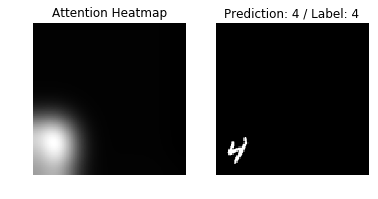

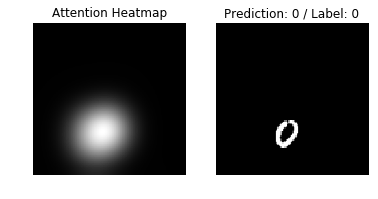

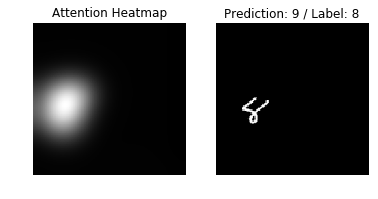

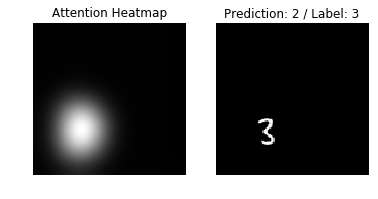

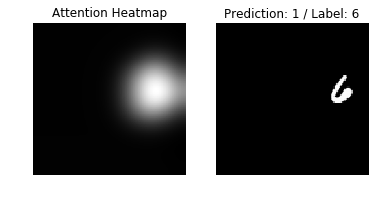

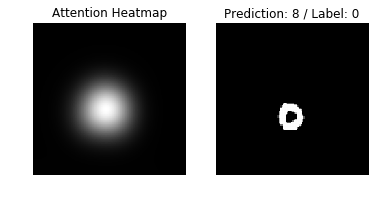

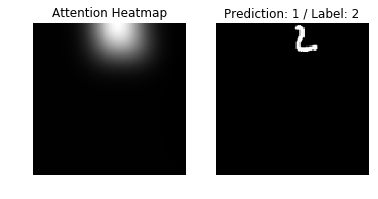

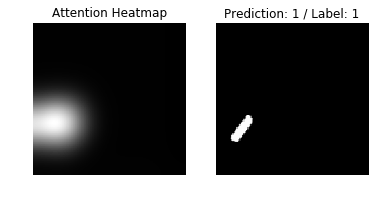

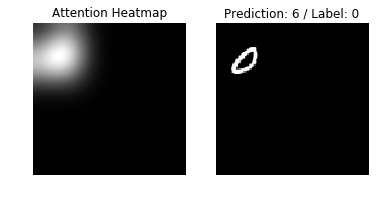

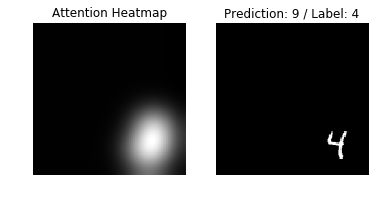

Sample Accuracy: 0.3


In [26]:
# Sampling test indexes
idx = random.sample(range(test_x.shape[0]), num_test_sample)

# Initialize fraction of test images and heatmap
test_fraction = np.zeros([10, img_size, img_size, 1])
heat_map = np.zeros([num_test_sample, img_size, img_size])

num_correct = 0.

# Test for Sampling data
for idx_sample in range(num_test_sample):
    
    # Get alpha(weight of fractions) and output for sample test data
    test_x_reshape = np.reshape(test_x, ([test_x.shape[0],img_size,img_size,1]))
    test_x_in = test_x_reshape[idx[idx_sample],:,:,:]
    alpha_, output_ = sess.run([alpha, output],feed_dict = {x_image: [test_x_in], y_target: [test_y[idx[idx_sample],:]]})
    alpha_size = int(np.sqrt(alpha_.shape[1]))
    alpha_reshape = np.reshape(alpha_, (alpha_size, alpha_size))
    alpha_resize = skimage.transform.pyramid_expand(alpha_reshape, upscale = 16, sigma=20)  
    
    # Make heatmap with alpha

    # Get labels for test samples
    y_test_pred = np.argmax(output_[:])
    y_test_true = np.argmax(test_y[idx[idx_sample], :])
    
    # Draw subplot for each sample 
    f1, ax = plt.subplots(1,2)
    ax[0].imshow(alpha_resize, cmap='gray')
    ax[0].axis("off")
    ax[0].set_title('Attention Heatmap')
    ax[1].imshow(test_x[idx[idx_sample],:,:], cmap='gray')
    ax[1].axis("off")
    ax[1].set_title('Prediction: ' + str(y_test_pred) + ' / ' + 'Label: ' + str(y_test_true))

    # Count correct
    if y_test_pred == y_test_true:
        num_correct += 1.

# Show results 
plt.show()
print('Sample Accuracy: ' + str(num_correct / num_test_sample))